In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer

In [ ]:
# датасет https://www.kaggle.com/datasets/nasa/meteorite-landings
df = pd.read_csv('meteorite-landings.csv')
df = df.drop(columns='GeoLocation') # Удалил столбец, дублирующий reclat и reclong
df

,name,id,nametype,recclass,mass,fall,year,reclat,reclong
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000
...,...,...,...,...,...,...,...,...,...
45711,Zillah 002,31356,Valid,Eucrite,172.0,Found,1990.0,29.03700,17.01850
45712,Zinder,30409,Valid,"Pallasite, ungrouped",46.0,Found,1999.0,13.78333,8.96667
45713,Zlin,30410,Valid,H4,3.3,Found,1939.0,49.25000,17.66667
45714,Zubkovsky,31357,Valid,L6,2167.0,Found,2003.0,49.78917,41.50460


Процент пропущенных значений по каждому стобцу

In [ ]:
(df.isna().sum() / len(df)).round(4) * 100

name         0.00
id           0.00
nametype     0.00
recclass     0.00
mass         0.29
fall         0.00
year         0.63
reclat      16.00
reclong     16.00
dtype: float64

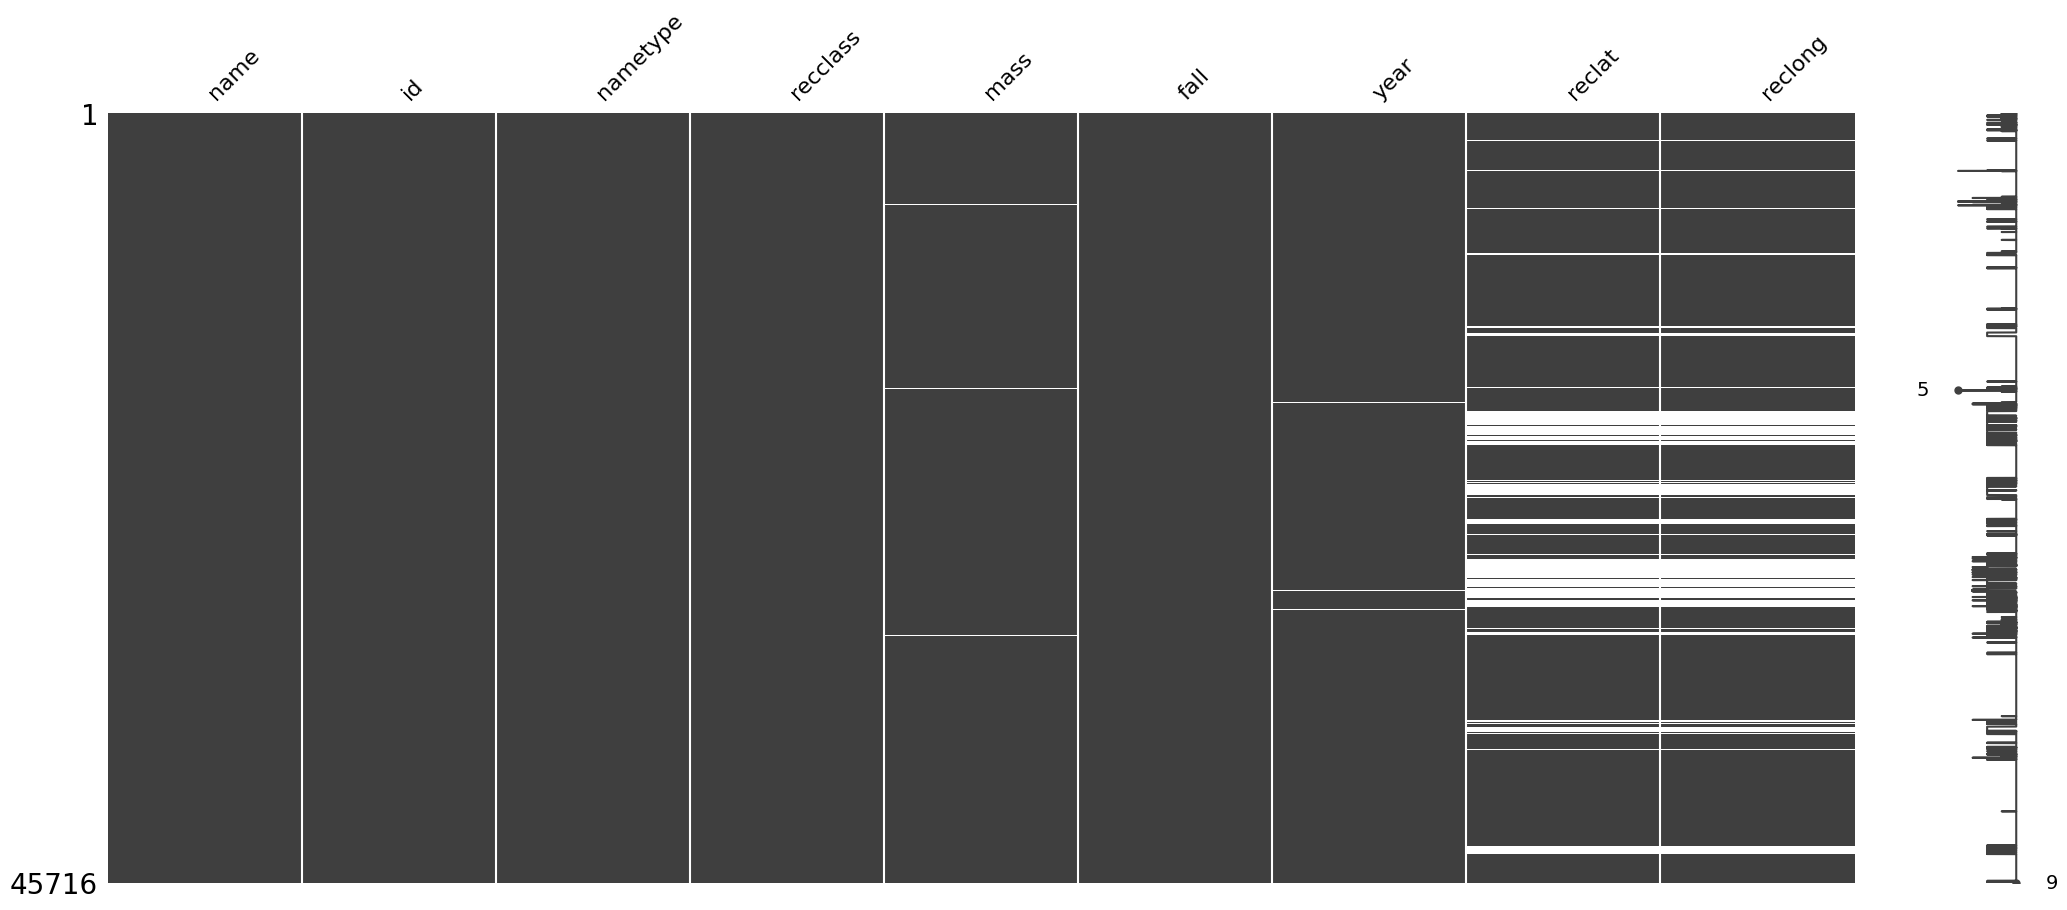

In [ ]:
msno.matrix(df);

Значения корреляции отсутствующих признаков

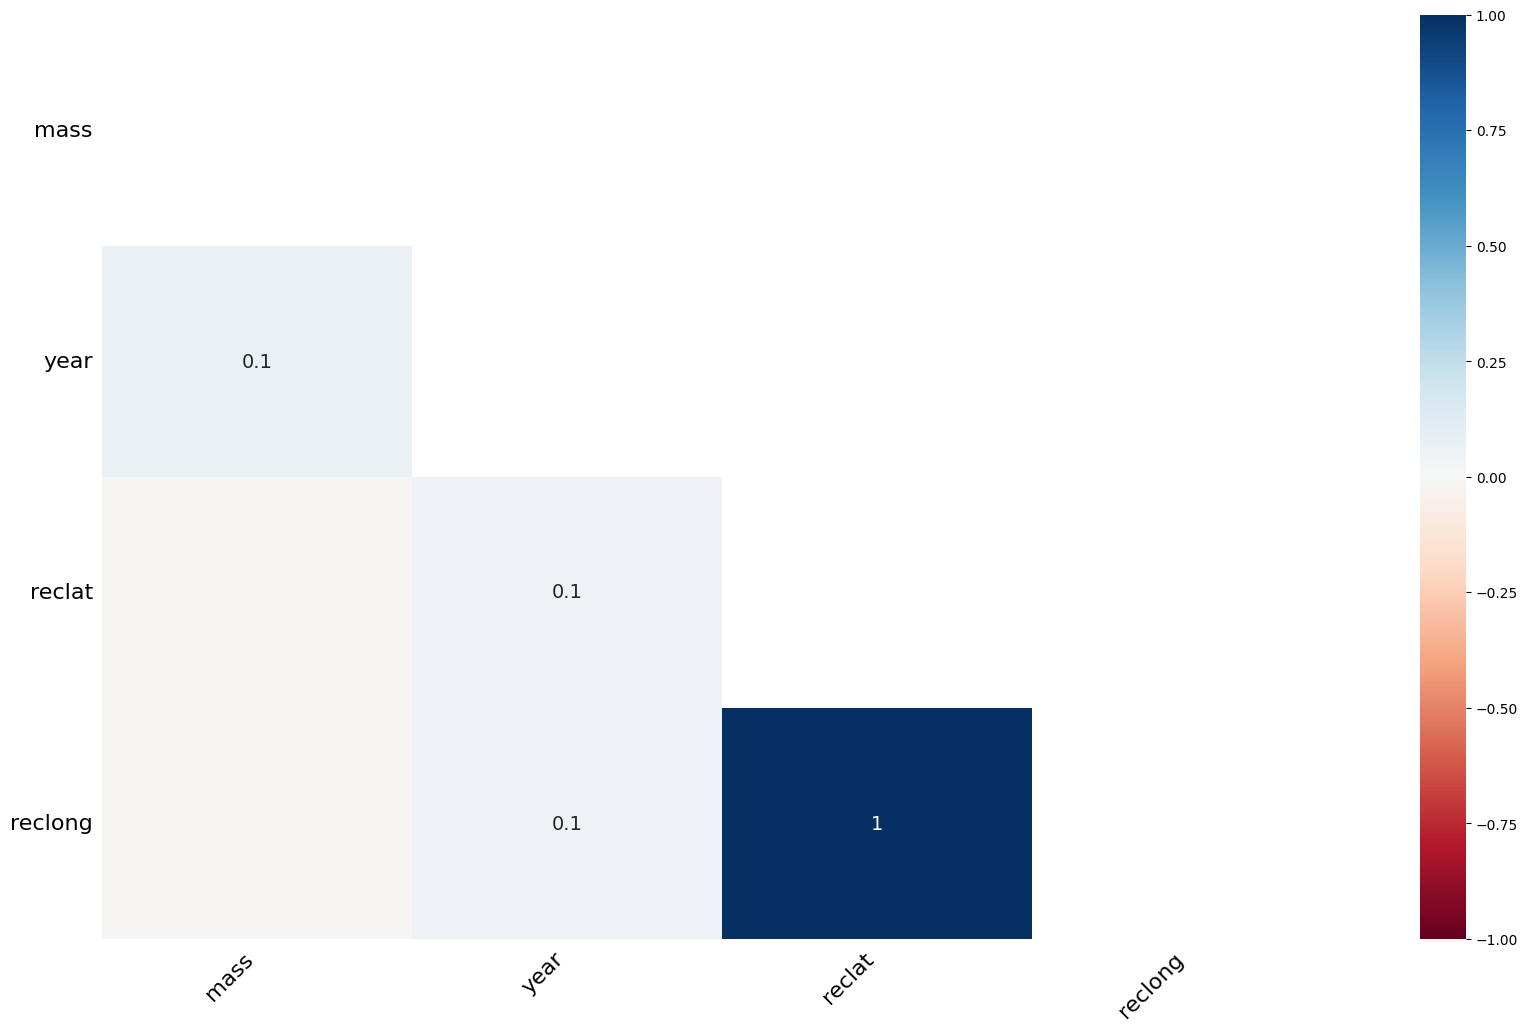

In [ ]:
msno.heatmap(df);

#Обработка пропусков

удаление пропусков

In [ ]:
df_drop = df.dropna(subset=['mass','year'])
df_drop.shape

(45311, 9)

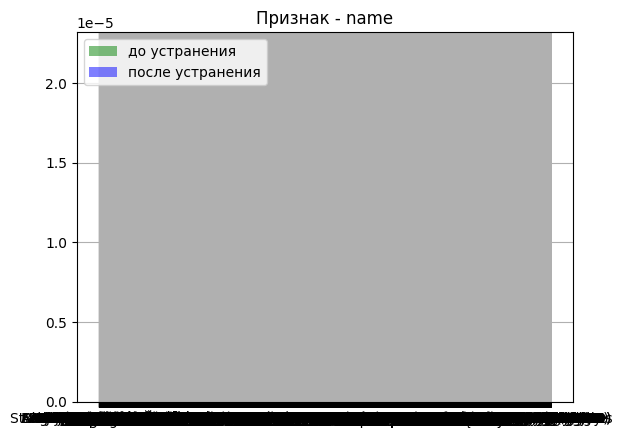

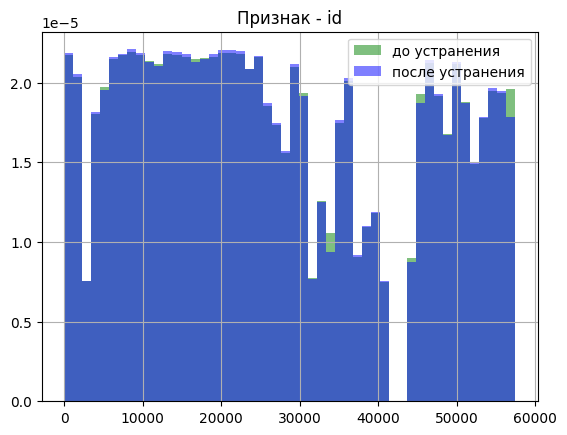

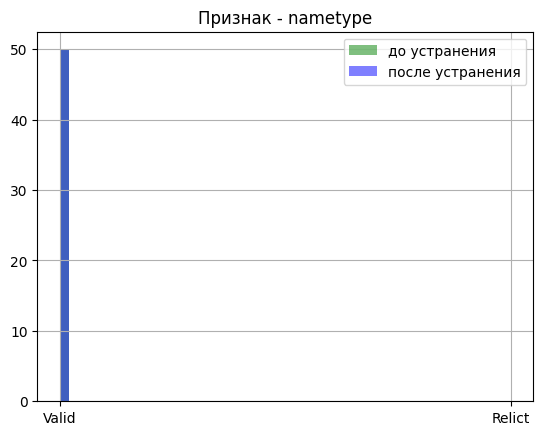

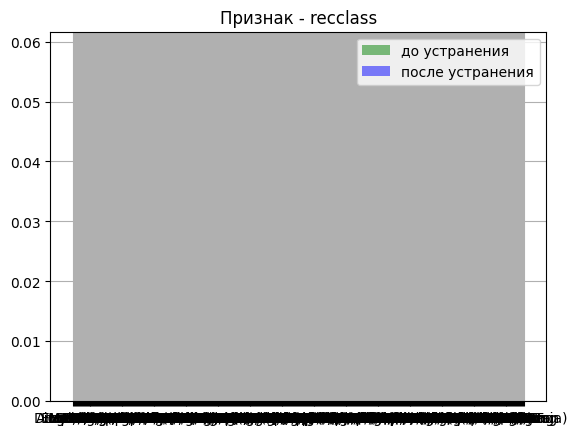

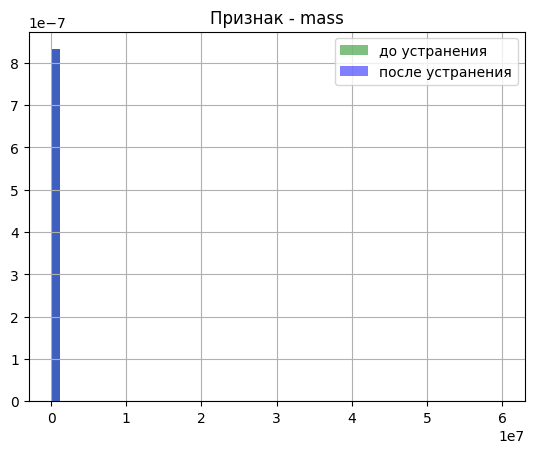

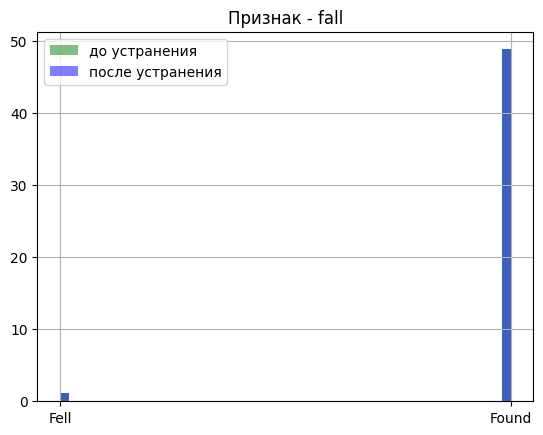

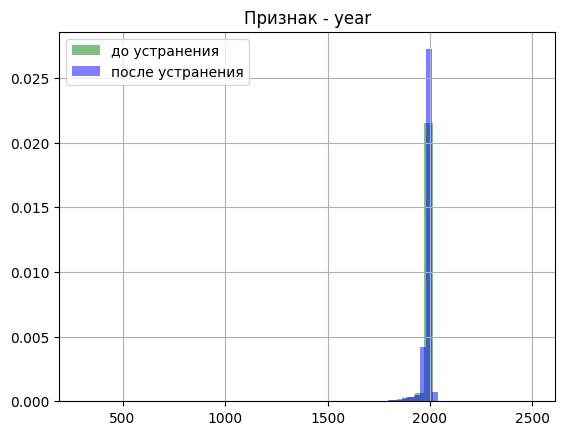

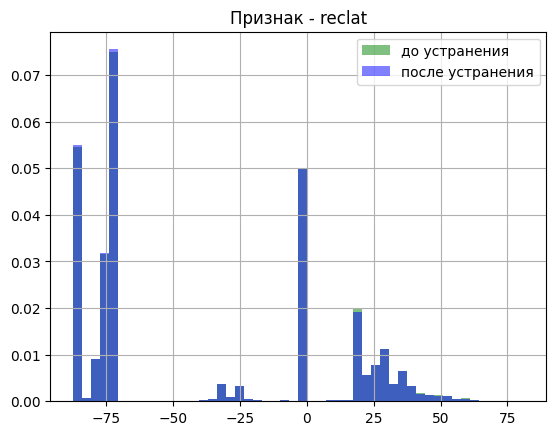

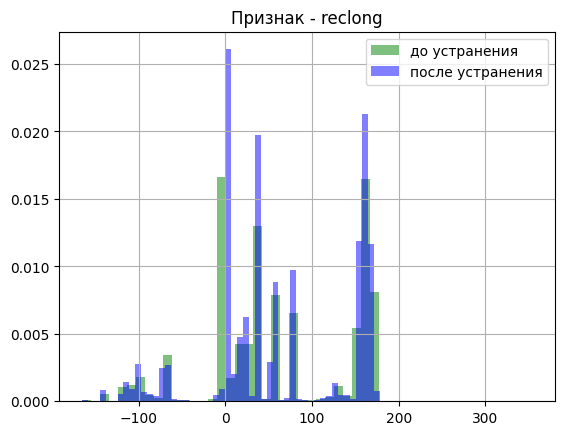

In [ ]:
# Функция показывает разницу между распределениями
# до и после устранения пропусков
def plot_hist_diff(old_ds, new_ds, cols):
    for c in cols:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.title.set_text('Признак - ' + str(c))
        old_ds[c].hist(bins=50, ax=ax, color='green', density=True, alpha=0.5)
        new_ds[c].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.5)
        ax.legend(['до устранения', 'после устранения'])
        plt.show()

plot_hist_diff(df, df_drop, df.columns)

замена пропусков (часть 1)

In [ ]:
# сгруппируем метеориты по классу и падению
bins = df.groupby(['fall', 'recclass'], group_keys=False)

# найдем медианную массу
bins['mass'].median()

fall   recclass      
Fell   Acapulcoite       1914.00
       Achondrite-ung       0.15
       Angrite           1500.00
       Aubrite           4850.00
       C                  992.50
                          ...   
Found  Unknown               NaN
       Ureilite            74.32
       Ureilite-an         30.60
       Ureilite-pmict      57.00
       Winonaite           48.35
Name: mass, Length: 581, dtype: float64

In [ ]:
# найдем медианный год
bins['year'].median()

fall   recclass      
Fell   Acapulcoite       1976.0
       Achondrite-ung    1917.0
       Angrite           1869.0
       Aubrite           1932.0
       C                 2012.0
                          ...  
Found  Unknown           1965.5
       Ureilite          2002.0
       Ureilite-an       2001.0
       Ureilite-pmict    1999.0
       Winonaite         1999.5
Name: year, Length: 581, dtype: float64

In [ ]:
warnings.filterwarnings('ignore')

print("Пропусков до замены на среднее:\n",
      df['mass'].isna().sum(),
      df['year'].isna().sum())

median_imputer_bins = df.copy()
median_imputer_bins['mass'] = bins['mass'].apply(lambda x: x.fillna(x.median()))
median_imputer_bins['year'] = bins['year'].apply(lambda x: x.fillna(x.median()))

print("Пропусков после замены:\n",
      median_imputer_bins['mass'].isna().sum(),
      median_imputer_bins['year'].isna().sum())

median_imputer_bins = median_imputer_bins.dropna(subset=['mass','year'])
print("Пропусков после удаления оставшихся:\n",
      median_imputer_bins['mass'].isna().sum(),
      median_imputer_bins['year'].isna().sum())

Пропусков до замены на среднее:
 131 288
Пропусков после замены:
 10 5
Пропусков после удаления оставшихся:
 0 0


#Кодирование категориальных признаков

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(drop = 'first', sparse_output = False)

onehot = median_imputer_bins.copy()
encoded_df = pd.DataFrame(onehotencoder.fit_transform(onehot[['nametype','fall']]))
encoded_df.columns = onehotencoder.get_feature_names_out()

onehot.index = np.arange(len(onehot))
onehot = onehot.join(encoded_df)
onehot.drop(['nametype', 'fall'], axis = 1, inplace = True)
onehot

,name,id,recclass,mass,year,reclat,reclong,nametype_Valid,fall_Found
0,Aachen,1,L5,21.0,1880.0,50.77500,6.08333,1.0,0.0
1,Aarhus,2,H6,720.0,1951.0,56.18333,10.23333,1.0,0.0
2,Abee,6,EH4,107000.0,1952.0,54.21667,-113.00000,1.0,0.0
3,Acapulco,10,Acapulcoite,1914.0,1976.0,16.88333,-99.90000,1.0,0.0
4,Achiras,370,L6,780.0,1902.0,-33.16667,-64.95000,1.0,0.0
...,...,...,...,...,...,...,...,...,...
45697,Zillah 002,31356,Eucrite,172.0,1990.0,29.03700,17.01850,1.0,1.0
45698,Zinder,30409,"Pallasite, ungrouped",46.0,1999.0,13.78333,8.96667,1.0,1.0
45699,Zlin,30410,H4,3.3,1939.0,49.25000,17.66667,1.0,1.0
45700,Zubkovsky,31357,L6,2167.0,2003.0,49.78917,41.50460,1.0,1.0


замена пропусков (часть 2)

In [ ]:
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

In [ ]:
%%time
imputer_missForest = IterativeImputer(
    estimator=RandomForestRegressor(),
    random_state=42
)

columns_to_impute = ['mass', 'year', 'nametype_Valid', 'fall_Found', 'reclat', 'reclong']

onehot_imputed = onehot.copy()
imputed_data = imputer_missForest.fit_transform(onehot_imputed[columns_to_impute])
onehot_imputed[columns_to_impute] = imputed_data

CPU times: user 58.1 s, sys: 60.5 ms, total: 58.1 s
Wall time: 58.3 s


In [ ]:
print(onehot.isna().sum())
print(onehot_imputed.isna().sum())

name                 0
id                   0
recclass             0
mass                 0
year                 0
reclat            7310
reclong           7310
nametype_Valid       0
fall_Found           0
dtype: int64
name              0
id                0
recclass          0
mass              0
year              0
reclat            0
reclong           0
nametype_Valid    0
fall_Found        0
dtype: int64


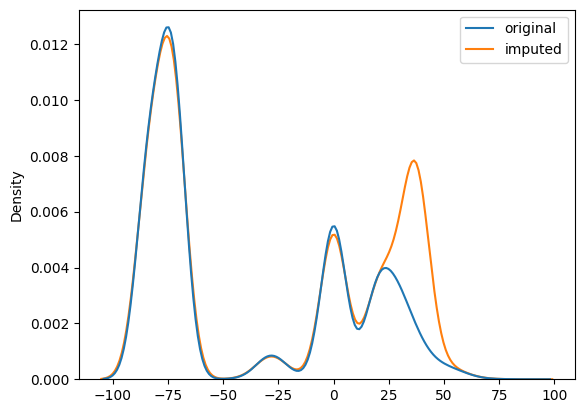

In [ ]:
reclat = pd.DataFrame({'original': onehot['reclat'].values, 'imputed': onehot_imputed['reclat'].values})
sns.kdeplot(data=reclat);

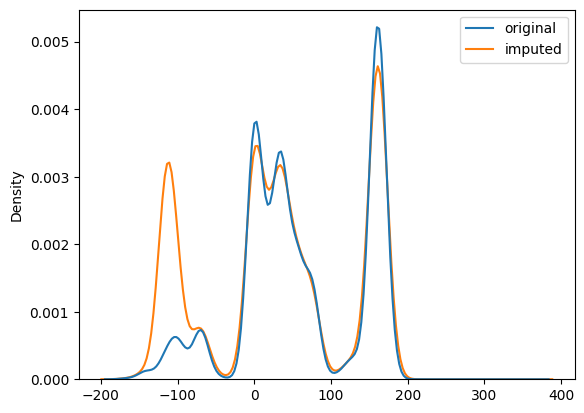

In [ ]:
reclong = pd.DataFrame({'original': onehot['reclong'].values, 'imputed': onehot_imputed['reclong'].values})
sns.kdeplot(data=reclong);

нормализация числовых признаков

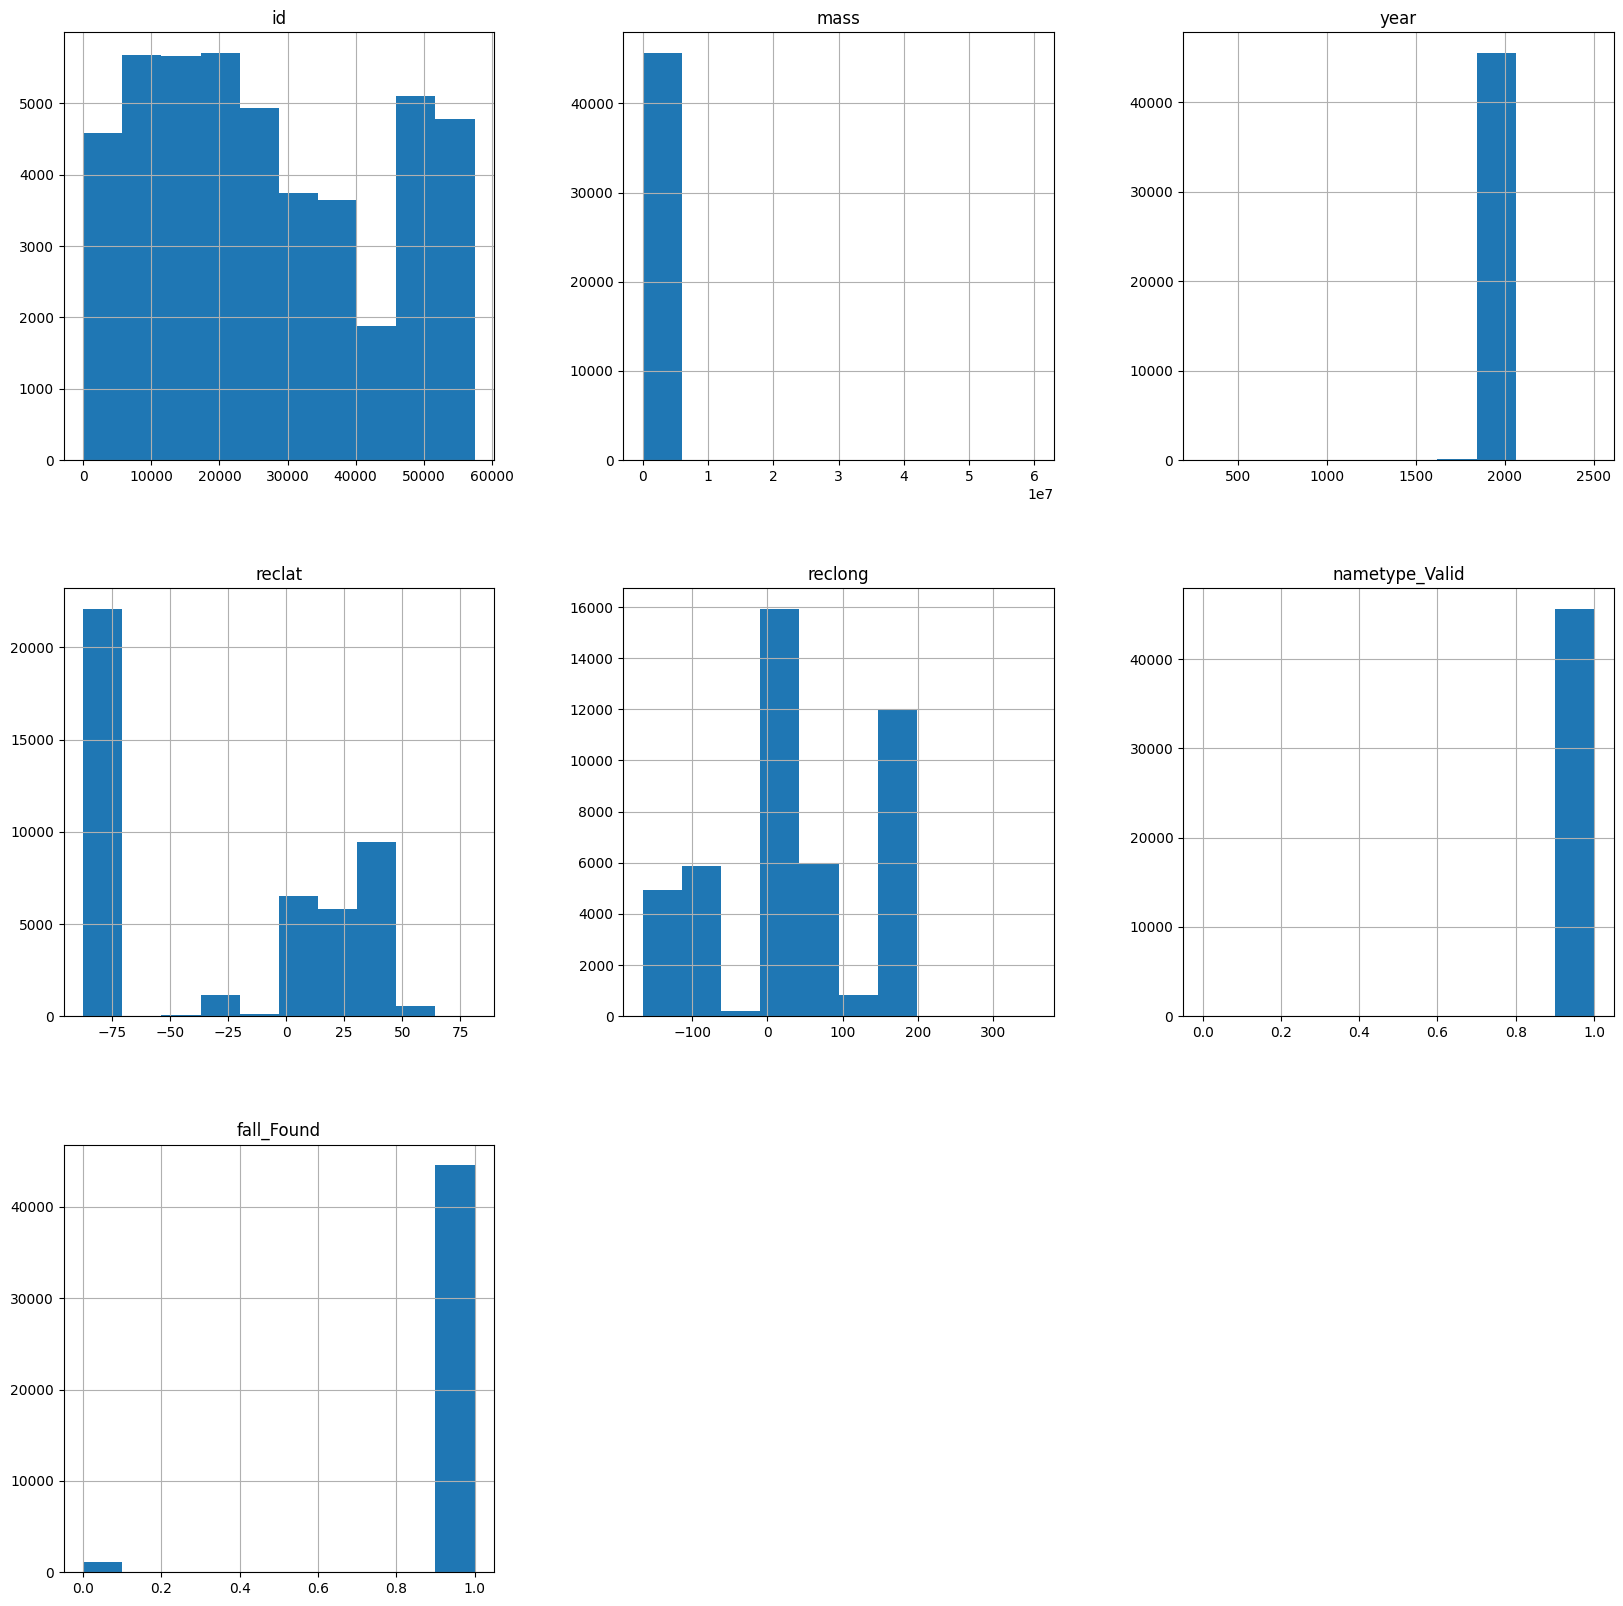

In [ ]:
onehot_imputed.hist(figsize=(20,20))
plt.show()

In [ ]:
from sklearn.preprocessing import Normalizer

norm = onehot_imputed[columns_to_impute].copy()
norm

,mass,year,nametype_Valid,fall_Found,reclat,reclong
0,21.0,1880.0,1.0,0.0,50.77500,6.08333
1,720.0,1951.0,1.0,0.0,56.18333,10.23333
2,107000.0,1952.0,1.0,0.0,54.21667,-113.00000
3,1914.0,1976.0,1.0,0.0,16.88333,-99.90000
4,780.0,1902.0,1.0,0.0,-33.16667,-64.95000
...,...,...,...,...,...,...
45697,172.0,1990.0,1.0,1.0,29.03700,17.01850
45698,46.0,1999.0,1.0,1.0,13.78333,8.96667
45699,3.3,1939.0,1.0,1.0,49.25000,17.66667
45700,2167.0,2003.0,1.0,1.0,49.78917,41.50460


In [ ]:
l2_norm = Normalizer(norm = 'l2').fit_transform(norm)
l2_norm

array([[ 1.11653850e-02,  9.99567801e-01,  5.31685001e-04,
         0.00000000e+00,  2.69963059e-02,  3.23441532e-03],
       [ 3.46087326e-01,  9.37800518e-01,  4.80676841e-04,
         0.00000000e+00,  2.70060256e-02,  4.91892474e-03],
       [ 9.99832952e-01,  1.82399432e-02,  9.34423320e-06,
         0.00000000e+00,  5.06613208e-04, -1.05589835e-03],
       ...,
       [ 1.70128599e-03,  9.99634407e-01,  5.15541210e-04,
         5.15541210e-04,  2.53904046e-02,  9.10789644e-03],
       [ 7.34171372e-01,  6.78608795e-01,  3.38796203e-04,
         3.38796203e-04,  1.68683817e-02,  1.40616009e-02],
       [ 1.00515008e-01,  9.93088275e-01,  5.02575038e-04,
         5.02575038e-04,  1.70791734e-02, -5.81395540e-02]])

In [ ]:
l1_norm = norm.copy()
for col in norm.columns:
    max = norm[col].max()
    min = norm[col].min()
    l1_norm[col] = (norm[col] - min) / (max - min)
l1_norm

,mass,year,nametype_Valid,fall_Found,reclat,reclong
0,3.500000e-07,0.717727,1.0,0.0,0.819670,0.329899
1,1.200000e-05,0.750000,1.0,0.0,0.851760,0.337881
2,1.783333e-03,0.750455,1.0,0.0,0.840091,0.100851
3,3.190000e-05,0.761364,1.0,0.0,0.618572,0.126048
4,1.300000e-05,0.727727,1.0,0.0,0.321598,0.193272
...,...,...,...,...,...,...
45697,2.866667e-06,0.767727,1.0,1.0,0.690686,0.350932
45698,7.666667e-07,0.771818,1.0,1.0,0.600178,0.335445
45699,5.500000e-08,0.744545,1.0,1.0,0.810621,0.352179
45700,3.611667e-05,0.773636,1.0,1.0,0.813820,0.398029


In [ ]:
l1_norm["nametype_Valid"].value_counts()

1.0    45628
0.0       74
Name: nametype_Valid, dtype: int64

#Обработка признака, который не является числовым или категориальным

In [ ]:
df = onehot_imputed
df['group'] = df['recclass'].str.extract(r'([A-Za-z]+)')
df['sub_class'] = df['recclass'].str.split('-', expand=True)[1]
df['sub_class'] = df['sub_class'].fillna('')

df['number'] = df['recclass'].str.extract(r'(\d+(?:\.\d+)?)')
df['number'] = pd.to_numeric(df['number'], errors='coerce')
df['number'].fillna(-1, inplace=True)

df.drop('recclass', axis=1, inplace=True)
df

,name,id,mass,year,reclat,reclong,nametype_Valid,fall_Found,group,sub_class,number
0,Aachen,1,21.0,1880.0,50.77500,6.08333,1.0,0.0,L,,5.0
1,Aarhus,2,720.0,1951.0,56.18333,10.23333,1.0,0.0,H,,6.0
2,Abee,6,107000.0,1952.0,54.21667,-113.00000,1.0,0.0,EH,,4.0
3,Acapulco,10,1914.0,1976.0,16.88333,-99.90000,1.0,0.0,Acapulcoite,,-1.0
4,Achiras,370,780.0,1902.0,-33.16667,-64.95000,1.0,0.0,L,,6.0
...,...,...,...,...,...,...,...,...,...,...,...
45697,Zillah 002,31356,172.0,1990.0,29.03700,17.01850,1.0,1.0,Eucrite,,-1.0
45698,Zinder,30409,46.0,1999.0,13.78333,8.96667,1.0,1.0,Pallasite,,-1.0
45699,Zlin,30410,3.3,1939.0,49.25000,17.66667,1.0,1.0,H,,4.0
45700,Zubkovsky,31357,2167.0,2003.0,49.78917,41.50460,1.0,1.0,L,,6.0


#Обработка выбросов

In [ ]:
from sklearn.ensemble import IsolationForest

digit_columns = ['mass', 'year', 'nametype_Valid', 'fall_Found', 'reclat', 'reclong',	'number']
X = df[digit_columns]
outliers = IsolationForest(contamination = 'auto', random_state = 42).fit_predict(X)
outliers

array([-1, -1, -1, ..., -1, -1,  1])

In [ ]:
filtered_X = X[outliers != -1]
print("Размер исходного датасета:", X.shape)
print("Размер фильтрованного датасета:", filtered_X.shape)

Размер исходного датасета: (45702, 7)
Размер фильтрованного датасета: (40157, 7)


In [ ]:
import scipy.stats as stats

# Функция вычисления верхней и нижней границы выбросов
def get_outlier_boundaries(df, col):
    # Межквантильный размах
    K2 = 1.5
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
    upper_boundary = df[col].quantile(0.75) + (K2 * IQR)
    return lower_boundary, upper_boundary

def diagnostic_plots(df, variable):
    fig, ax = plt.subplots(figsize=(10,7))
    ax.remove()
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist='norm', plot=plt)
    # скрипичная диаграмма
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])
    fig.suptitle(variable)
    plt.show()

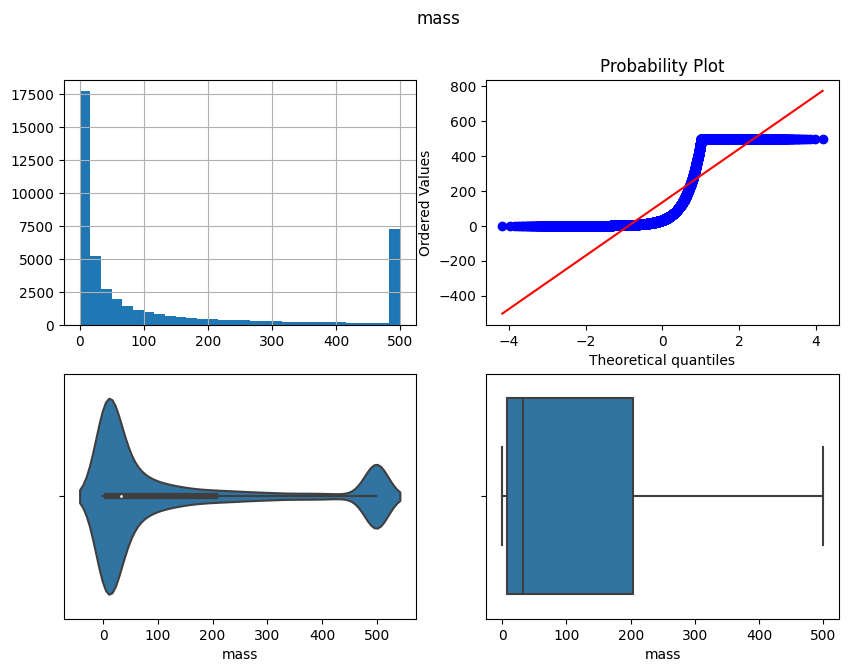

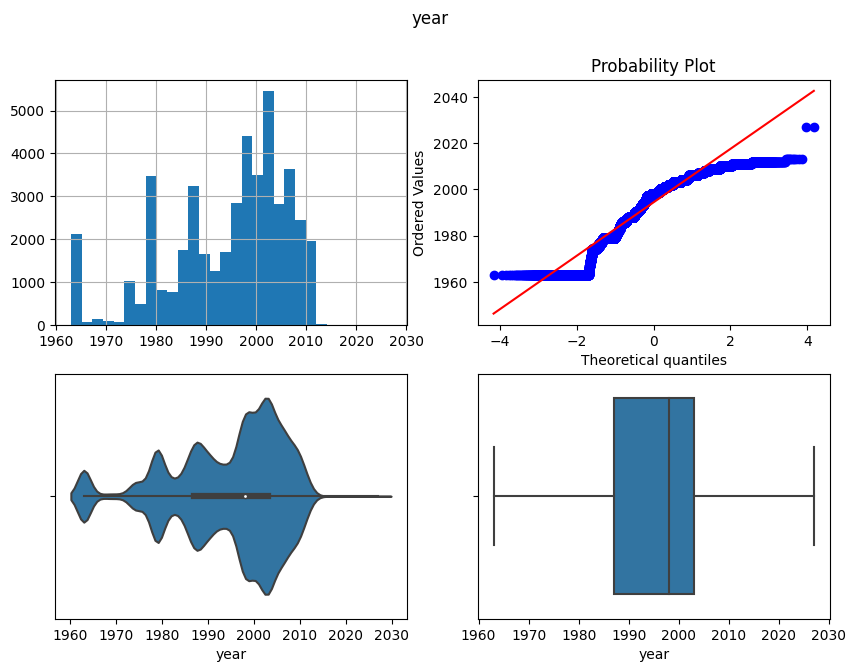

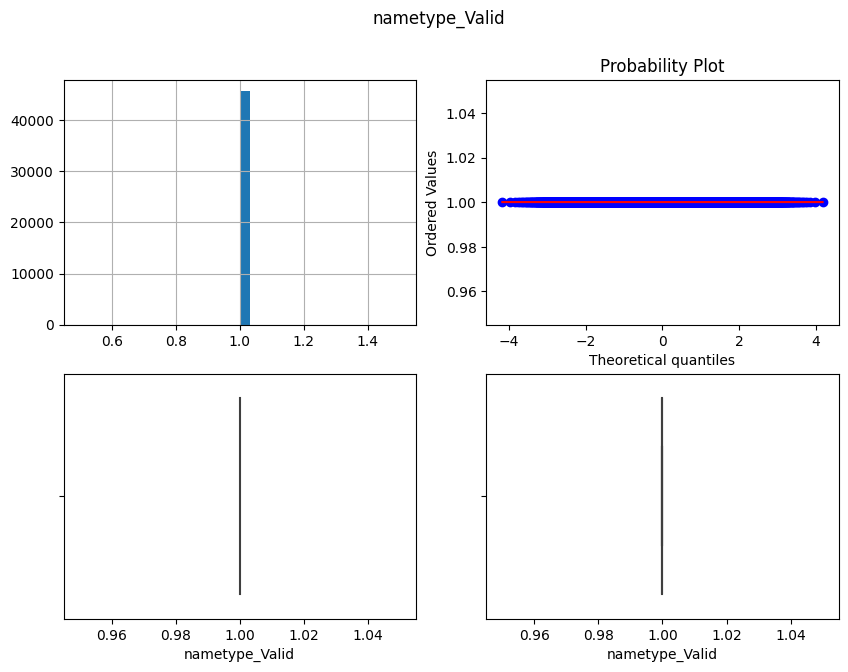

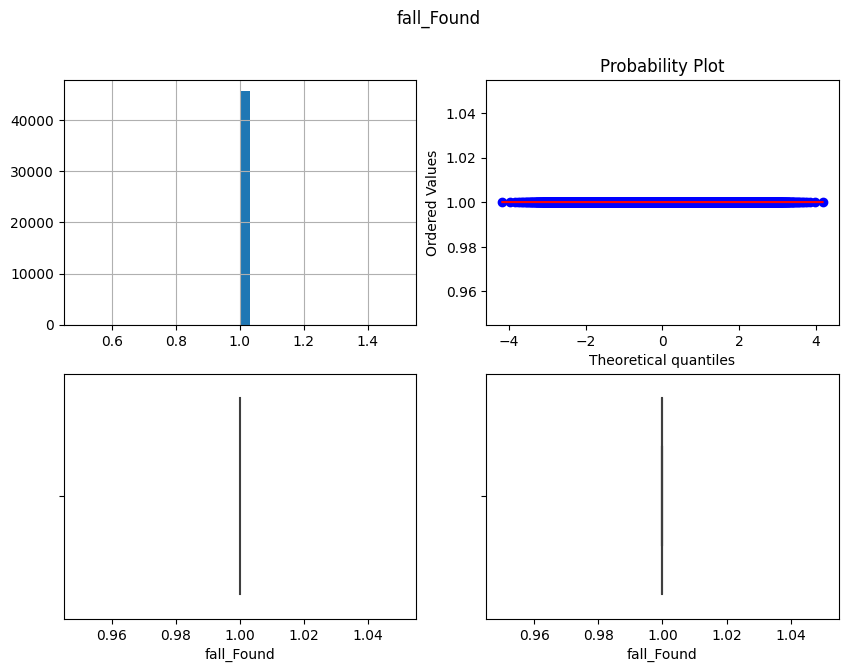

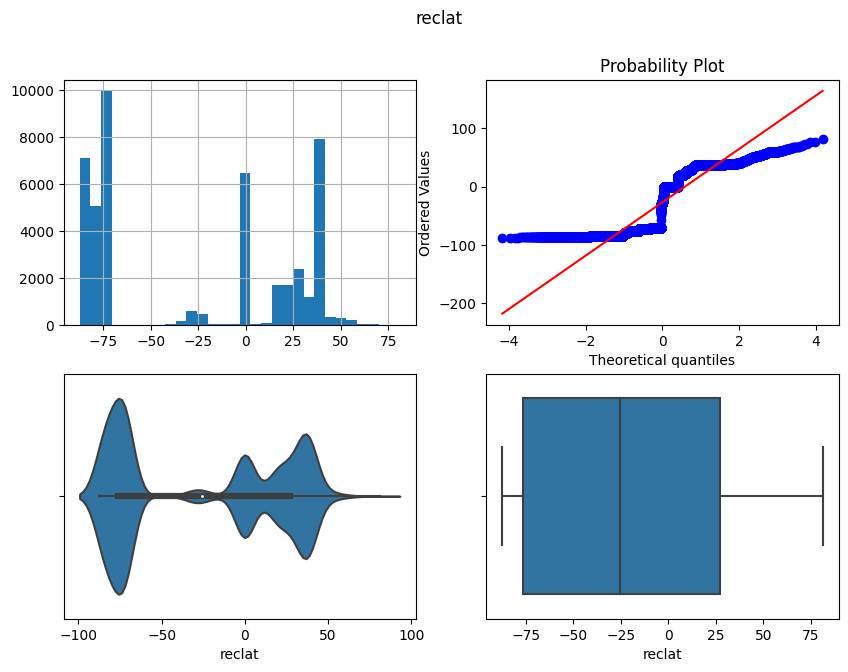

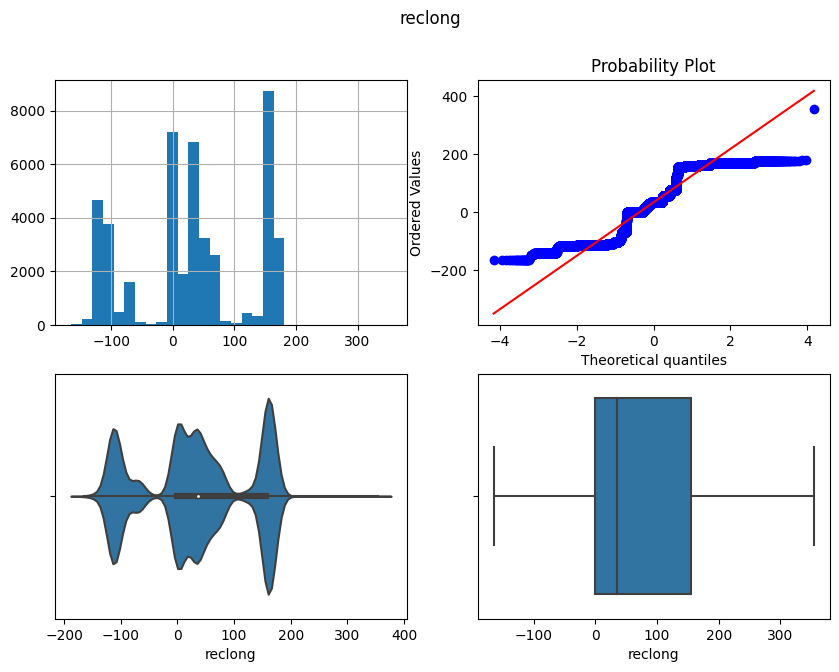

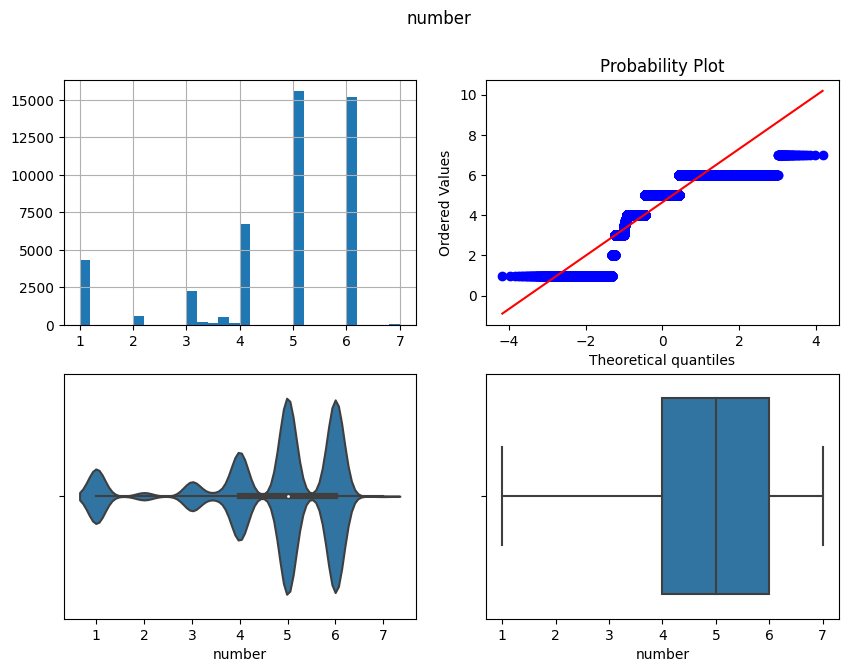

In [ ]:
for col in digit_columns:
     # Вычисление верхней и нижней границы
     lower_boundary, upper_boundary = get_outlier_boundaries(X, col)
     # Изменение данных
     X[col] = np.where(X[col] > upper_boundary, upper_boundary,
                       np.where(X[col] < lower_boundary, lower_boundary, X[col]))
     diagnostic_plots(X, col)

#Отбор признаков

методы фильтрации

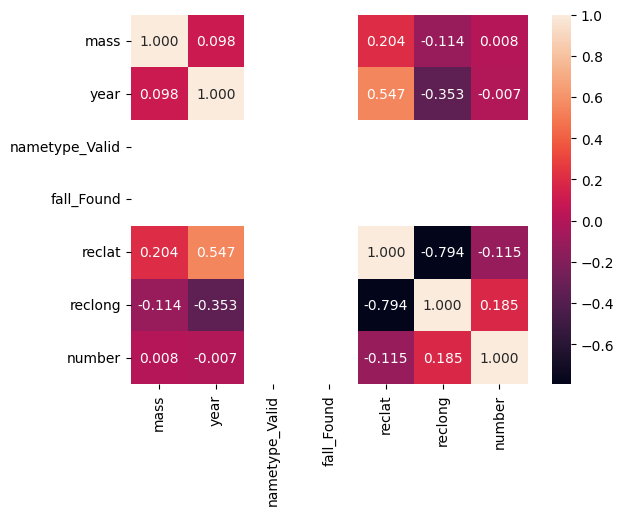

In [ ]:
sns.heatmap(filtered_X.corr(), annot=True, fmt='.3f');

In [ ]:
# Формирование DataFrame с сильными корреляциями
def make_corr_df(df):
    cr = df.corr()
    cr = cr.abs().unstack()
    cr = cr.sort_values(ascending=False)
    cr = cr[cr >= 0.5]
    cr = cr[cr < 1]
    cr = pd.DataFrame(cr).reset_index()
    cr.columns = ['f1', 'f2', 'corr']
    return cr

# Обнаружение групп коррелирующих признаков
def corr_groups(cr):
    grouped_feature_list = []
    correlated_groups = []

    for feature in cr['f1'].unique():
        if feature not in grouped_feature_list:
            # находим коррелирующие признаки
            correlated_block = cr[cr['f1'] == feature]
            cur_dups = list(correlated_block['f2'].unique()) + [feature]
            grouped_feature_list = grouped_feature_list + cur_dups
            correlated_groups.append(cur_dups)
    return correlated_groups

corr_df = make_corr_df(filtered_X)
print(corr_df)
print("Группы коррелирующих признаков:", corr_groups(corr_df))

        f1       f2      corr
0   reclat  reclong  0.794151
1  reclong   reclat  0.794151
2     year   reclat  0.546583
3   reclat     year  0.546583
Группы коррелирующих признаков: [['reclong', 'year', 'reclat']]


Корреляционная матрица после применения PCA:


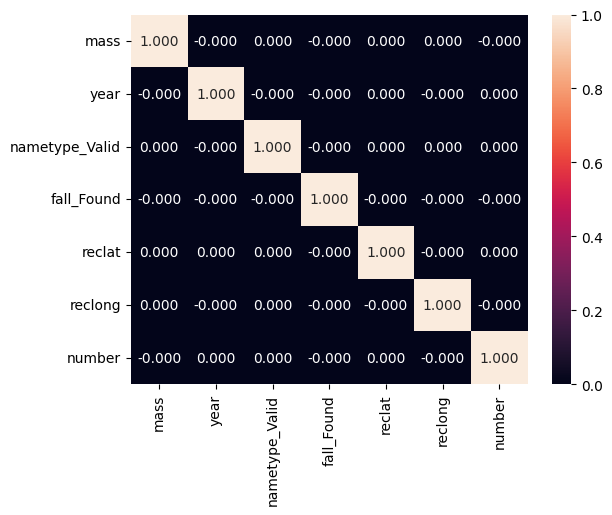

In [ ]:
from sklearn.decomposition import PCA

# Используем метод главных компонент для уменьшения корреляции
pca = PCA() # n_components = filtered_X.shape[1]
df_pca = pca.fit_transform(filtered_X)

# Преобразуем результат PCA обратно в датафрейм
df_pca = pd.DataFrame(df_pca, columns=digit_columns)

print("Корреляционная матрица после применения PCA:")
sns.heatmap(df_pca.corr(), annot=True, fmt='.3f');

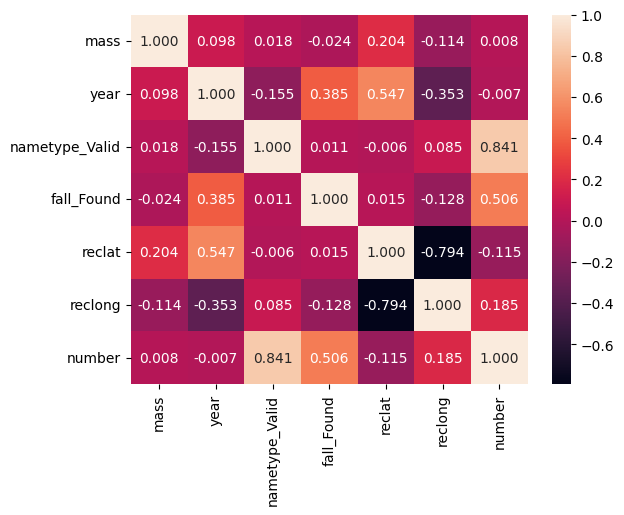

In [ ]:
# Обратное преобразование
inverse = pd.DataFrame(pca.inverse_transform(df_pca), columns=digit_columns)
sns.heatmap(inverse.corr(), annot=True, fmt='.3f');

методы обёртывания

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

print(filtered_X.isna().sum())
print(filtered_X.isnull().sum())

estimator = RandomForestRegressor()
efs = EFS(estimator,
           min_features=3,
           max_features=5,
           scoring='accuracy',
           print_progress=True,
           cv=3)

X_ALL = filtered_X.drop('mass', axis=1)
Y = filtered_X['mass']
efs = efs.fit(X_ALL, Y)

print('Best accuracy score: %.2f' % efs.best_score_)
print('Best subset (indices):', efs.best_idx_)
print('Best subset (corresponding names):', efs.best_feature_names_)

mass              0
year              0
nametype_Valid    0
fall_Found        0
reclat            0
reclong           0
number            0
dtype: int64
mass              0
year              0
nametype_Valid    0
fall_Found        0
reclat            0
reclong           0
number            0
dtype: int64


Features: 63/63

UnboundLocalError: ignored

Масштабирование признаков

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
# Разделим выборку на обучающую и тестовую
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_ALL, Y,
                                                    test_size=0.2,
                                                    random_state=1)

def arr_to_df(arr_scaled):
    res = pd.DataFrame(arr_scaled, columns=X_ALL.columns)
    return res

# Преобразуем массивы в DataFrame
X_train_df = arr_to_df(X_train)
X_test_df = arr_to_df(X_test)

X_train_df.shape, X_test_df.shape

((6995, 6), (1749, 6))

In [ ]:
# построение плотности распределения
def draw_kde(df1, df2, label1, label2):
    col_list = ['year','nametype_Valid','fall_Found','reclat','reclong','number']
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, figsize=(12, 5))
    # первый график
    ax1.set_title(label1)
    sns.kdeplot(data=df1[col_list], ax=ax1)
    # второй график
    ax2.set_title(label2)
    sns.kdeplot(data=df2[col_list], ax=ax2)
    plt.show()

Стандартизация

In [ ]:
cs11 = StandardScaler()

cs11_scaled = arr_to_df(cs11.fit_transform(X_ALL))
cs11_scaled

,year,nametype_Valid,fall_Found,reclat,reclong,number
0,0.793508,0.0,0.0,0.657156,-0.983746,-0.013663
1,-1.213366,0.0,0.0,1.216326,-2.430129,-0.013663
2,1.685452,0.0,0.0,1.131239,-0.311993,-0.945482
3,0.459029,0.0,0.0,1.225495,-0.574380,-0.790179
4,-0.432915,0.0,0.0,1.230931,-0.934123,0.762853
...,...,...,...,...,...,...
8739,-0.098436,0.0,0.0,-0.929459,1.158466,0.762853
8740,-0.098436,0.0,0.0,-0.929373,1.157760,0.762853
8741,-0.098436,0.0,0.0,-0.929642,1.158924,0.762853
8742,-0.098436,0.0,0.0,-0.930021,1.156915,0.762853


In [ ]:
cs11_scaled.describe()

,year,nametype_Valid,fall_Found,reclat,reclong,number
count,8.744000e+03,8744.0,8744.0,8.744000e+03,8.744000e+03,8.744000e+03
mean,-3.250424e-15,0.0,0.0,9.101188e-17,-2.080272e-16,-8.581120e-16
std,1.000057e+00,0.0,0.0,1.000057e+00,1.000057e+00,1.000057e+00
min,-4.558157e+00,0.0,0.0,-1.129544e+00,-2.615783e+00,-4.672759e+00
25%,-6.559013e-01,0.0,0.0,-9.344411e-01,-7.600818e-01,-1.366274e-02
50%,-3.214222e-01,0.0,0.0,-8.450906e-01,-2.378413e-01,-1.366274e-02
75%,7.935080e-01,0.0,0.0,1.057039e+00,1.163198e+00,7.628534e-01
max,2.019931e+00,0.0,0.0,1.695515e+00,1.300738e+00,1.539369e+00


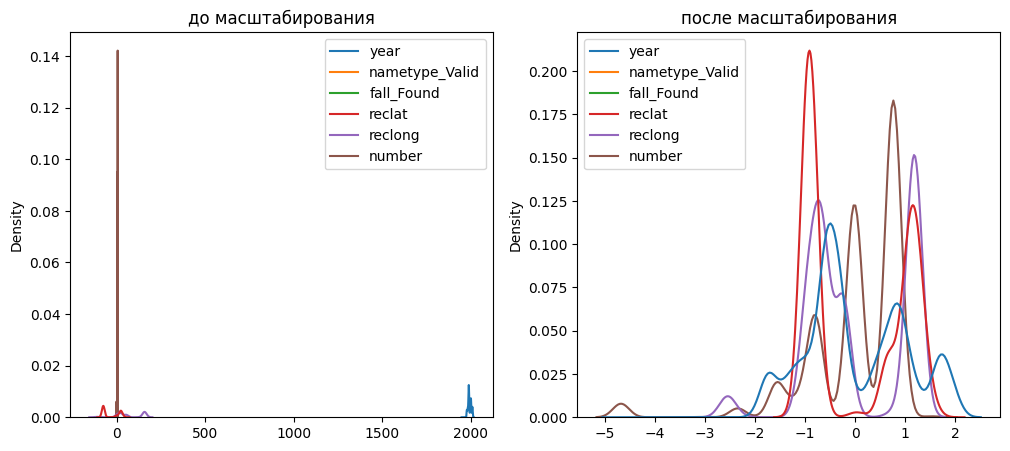

In [ ]:
draw_kde(X_ALL, cs11_scaled, 'до масштабирования', 'после масштабирования')

MinMax-масштабирование

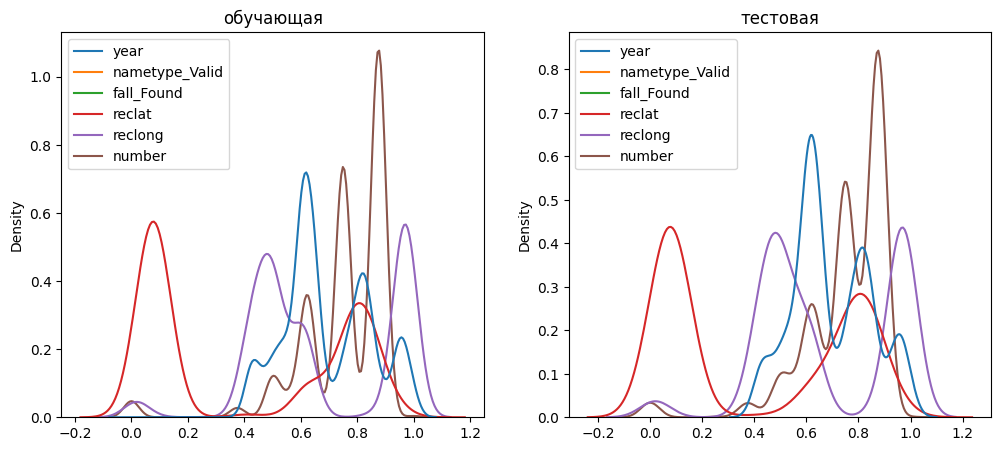

In [ ]:
mms = MinMaxScaler()
mms.fit(X_train)

mms_scaled_train_temp = mms.transform(X_train)
mms_scaled_test_temp = mms.transform(X_test)

mms_scaled_train = arr_to_df(mms_scaled_train_temp)
mms_scaled_test = arr_to_df(mms_scaled_test_temp)

draw_kde(mms_scaled_train, mms_scaled_test, 'обучающая', 'тестовая')